Idea is to test out-of-box [SSD](https://github.com/amdegroot/ssd.pytorch) on the current dataset

In [1]:
# !cd ../../../ && git clone https://github.com/amdegroot/ssd.pytorch

In [1]:
from __future__ import division, print_function
import os, sys

SSD_PYTORCH_PATH = os.path.join("..", "..", "..", "ssd.pytorch")

In [2]:
# !cd {SSD_PYTORCH_PATH} && mkdir weights && cd weights && wget https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth

In [3]:
if SSD_PYTORCH_PATH not in sys.path:
    sys.path.append(SSD_PYTORCH_PATH)

In [4]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.serialization import load_lua
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd

In [5]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights(os.path.join(SSD_PYTORCH_PATH, 'weights', 'ssd300_mAP_77.43_v2.pth'))

Loading weights into state dict...
Finished!


In [6]:
import numpy as np
import pandas as pd

INPUT_PATH = '../data'
TRAIN_TEST_DATA = os.path.join(INPUT_PATH, 'imgs')
TRAIN_CSV_PATH = os.path.join(INPUT_PATH, 'train.csv')
TEST_CSV_PATH = os.path.join(INPUT_PATH, 'test.csv')

CLASS_CODES_DF = pd.read_csv(os.path.join(INPUT_PATH, 'class_codes.csv'))
TRAIN_CSV_DF = pd.read_csv(TRAIN_CSV_PATH)
TEST_CSV_DF = pd.read_csv(TEST_CSV_PATH)

train_ids = TRAIN_CSV_DF['id'].values
train_classes = TRAIN_CSV_DF['class'].values

test_ids = TEST_CSV_DF['id'].values

In [7]:
import cv2
from skimage.io import imread


def get_filename(image_id, image_type):
    """
    Method to get image file path from its id and type
    """
    check_dir = False
    ext = ''
    prefix = '' 
    if "Train" in image_type: 
        data_path = TRAIN_TEST_DATA
    elif "Test" in image_type:
        data_path = TRAIN_TEST_DATA
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)
    if len(ext) > 0:
        return os.path.join(data_path, "{}{}.{}".format(prefix, image_id, ext))
    return os.path.join(data_path, "{}{}".format(prefix, image_id, ext))    
    

_gb = TRAIN_CSV_DF.groupby('id')
_id_class_gb = _gb['class']    

_gb_test = TEST_CSV_DF.groupby('id')
_id_class_gb_test = _gb_test['class']    


def get_label(image_id, image_type):
    if image_type == "Train":
        return _id_class_gb.get_group(image_id).values[0]
    elif image_type == "Test":
        return _id_class_gb_test.get_group(image_id).values[0]
    else:
        raise Exception("image_type '{}' is unknown".format(image_type))
    
    
def get_image_data(image_id, image_type):
    fname = get_filename(image_id, image_type)
    
    img = cv2.imread(fname)
    if img is None:
        img = imread(fname)
        assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)    
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    return img

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

In [9]:
def preproc(image):
    x = cv2.resize(image, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    return torch.from_numpy(x).permute(2, 0, 1)

In [10]:
img = get_image_data(train_ids[0], "Train")
train_ids[0]

70709

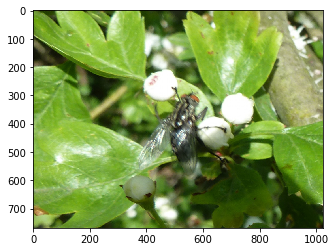

In [11]:
plt.imshow(img)

In [12]:
x = preproc(img)

In [13]:
x.size(), x.unsqueeze(0).size()

(torch.Size([3, 300, 300]), torch.Size([1, 3, 300, 300]))

In [22]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
# y = net(xx)

In [23]:
sources = list()
loc = list()
conf = list()

# apply vgg up to conv4_3 relu
for k in range(23):
    xx = net.vgg[k](xx)

# s = self.L2Norm(x)
# sources.append(s)

In [24]:
xx.size()

torch.Size([1, 512, 38, 38])

In [21]:
net.L2Norm??

In [25]:
norm = xx.pow(2).sum(dim=1, keepdim=True).sqrt()

In [26]:
norm.size()

torch.Size([1, 1, 38, 38])

In [33]:
xx = Variable(torch.randn((1, 3, 300, 300)))  
norm = xx.pow(2).sum(dim=1, keepdim=True).sqrt()
print(norm.size())
xx.div_(norm)

torch.Size([1, 1, 300, 300])


RuntimeError: div_ only supports scalar multiplication